In [1]:
# Carga de paquetes necesarios para graficar
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Para leer archivos
import geopandas as gpd # Para hacer cosas geográficas
import seaborn as sns # Para hacer plots lindos
import networkx as nx # Construcción de la red en NetworkX
import scipy

#import template_funciones_2
from template_funciones_2 import construye_adyacencia, calculaLU, grado_inv, calcula_matriz_C, calcula_pagerank, calcula_matriz_C_continua, calcula_B, num_condicion, maximos, calcula_v, sortmuseos, top3museos, laplaciano_iterativo, modularidad_iterativo, calcula_R,A_simetrizada


[[4, 5, 6, 7], [0, 1, 2, 3]]
[[0, 1, 2, 3], [4, 5, 6, 7]]


# Preambulo

En esta sección cargamos los datos y los visualizamos. También construimos la matriz de adyacencia de la red de museos.

## Carga de datos de los museos

El listado de los museos, con el que se construye el [mapa](https://mapas.museosabiertos.org/museos/caba/), lo podemos encontrar [acá](https://github.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/blob/principal/data/export.geojson?short_path=bc357f3). También descargamos los barrios de CABA como complemento para los gráficos.

In [2]:
# Leemos el archivo, retenemos aquellos museos que están en CABA, y descartamos aquellos que no tienen latitud y longitud
museos = gpd.read_file('https://raw.githubusercontent.com/MuseosAbiertos/Leaflet-museums-OpenStreetMap/refs/heads/principal/data/export.geojson')
barrios = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')

## Visualización

<Axes: >

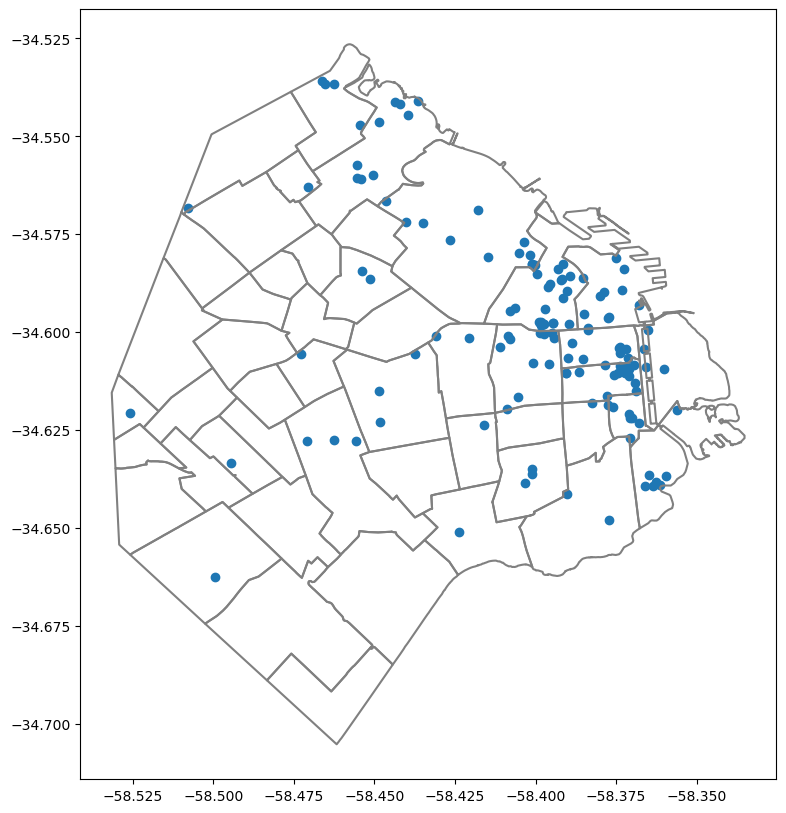

In [3]:
# Armamos el gráfico para visualizar los museos
fig, ax = plt.subplots(figsize=(10, 10))
barrios.boundary.plot(color='gray',ax=ax)
museos.plot(ax=ax)

## Cálculo de la matriz de distancias

Ahora construimos la matriz de distancias entre todos los museos. Como la tierra es un [geoide](https://es.wikipedia.org/wiki/Geoide) (es decir que no es [plana](https://es.wikipedia.org/wiki/Terraplanismo)), el cálculo de distancias no es una operación obvia. Una opción es proyectar a un [sistema de coordenadas local](https://geopandas.org/en/stable/docs/user_guide/projections.html), de forma tal que las distancias euclideas se correspondan con las distancias en metros. En este notebook usamos [EPSG](https://en.wikipedia.org/wiki/EPSG_Geodetic_Parameter_Dataset) 22184.

In [4]:
# En esta línea:
# Tomamos museos, lo convertimos al sistema de coordenadas de interés, extraemos su geometría (los puntos del mapa),
# calculamos sus distancias a los otros puntos de df, redondeamos (obteniendo distancia en metros), y lo convertimos a un array 2D de numpy
D = museos.to_crs("EPSG:22184").geometry.apply(lambda g: museos.to_crs("EPSG:22184").distance(g)).round().to_numpy()
print(D)

[[   0. 9276.  577. ... 2367. 9054.  261.]
 [9276.    0. 8992. ... 8222. 7578. 9466.]
 [ 577. 8992.    0. ... 1791. 9246.  577.]
 ...
 [2367. 8222. 1791. ...    0. 9955. 2332.]
 [9054. 7578. 9246. ... 9955.    0. 9314.]
 [ 261. 9466.  577. ... 2332. 9314.    0.]]


### Matriz de adyacencia: construimos una matriz conectando a cada museo con los $m$ más cercanos

In [5]:
def construye_adyacencia(D,m):
    # Función que construye la matriz de adyacencia del grafo de museos
    # D matriz de distancias, m cantidad de links por nodo
    # Retorna la matriz de adyacencia como un numpy.
    D = D.copy()
    l = [] # Lista para guardar las filas
    for fila in D: # recorriendo las filas, anexamos vectores lógicos
        l.append(fila<=fila[np.argsort(fila)[m]] ) # En realidad, elegimos todos los nodos que estén a una distancia menor o igual a la del m-esimo más cercano
    A = np.asarray(l).astype(int) # Convertimos a entero
    np.fill_diagonal(A,0) # Borramos diagonal para eliminar autolinks
    return(A)

m = 4 # Cantidad de links por nodo
A = construye_adyacencia(D,m)

## Construcción de la red en NetworkX (sólo para las visualizaciones)

In [6]:
G = nx.from_numpy_array(A) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

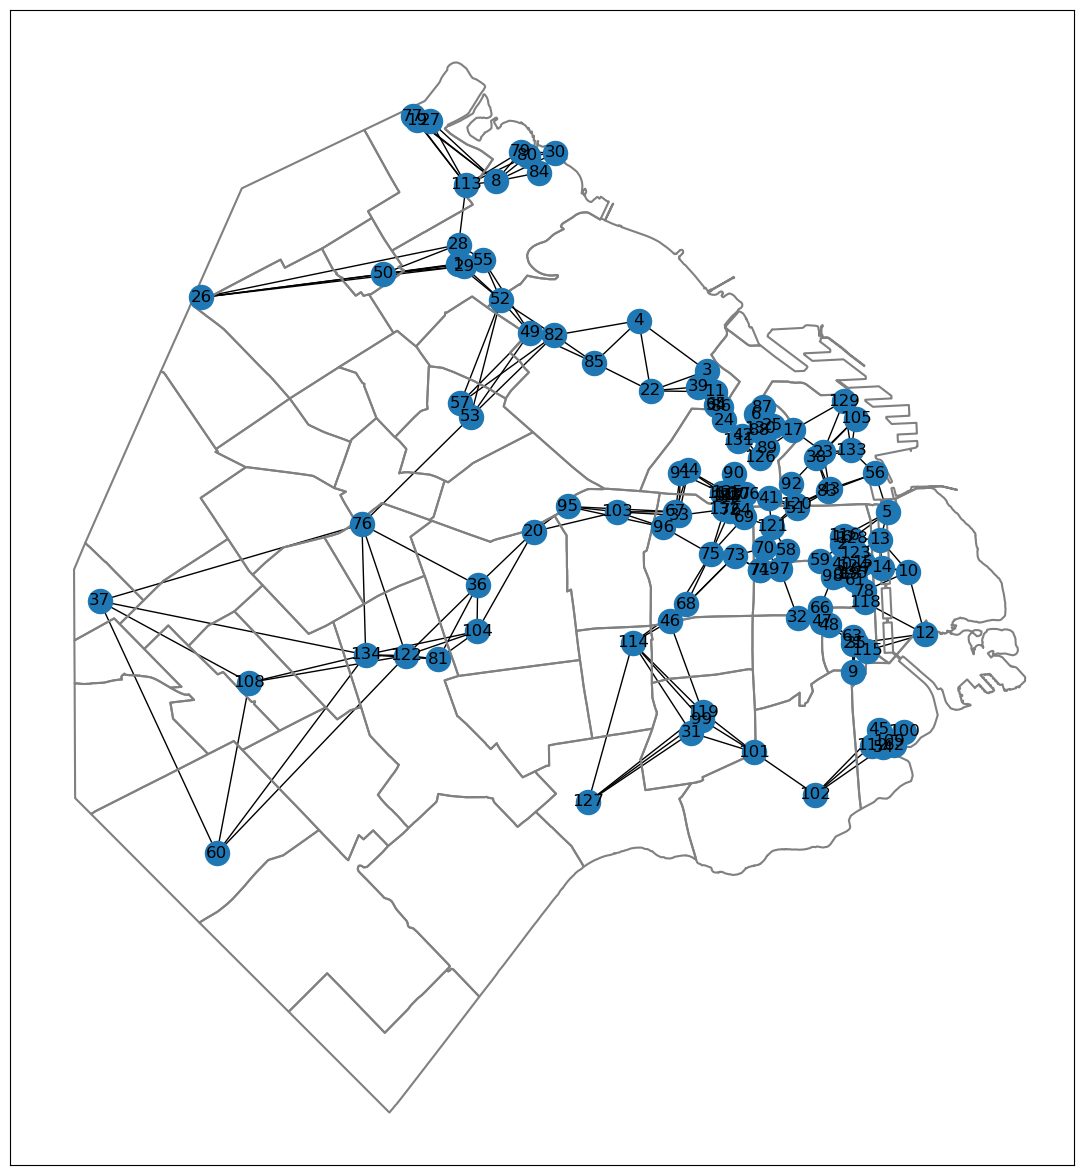

In [7]:
fig, ax = plt.subplots(figsize=(15, 15)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax) # Graficamos los museos

# Resolución del TP 1

## Punto 1:
Para demostrar que el vector de rankings p es solución de la ecuación M p = b.

$ M =  \frac{N}{\alpha}(I - (1 − \alpha)C) $ y b = **1**
$$$$
En primer lugar, despejamos el valor de p utilizando definición de la ecuación 3:

$ p = (1 − \alpha) C p +  \frac{\alpha}{N} \textbf{1} \\ $
$ p - (1 − \alpha) C p =  \frac{\alpha}{N} \textbf{1} \\ $
$ p * ( I - (1 − \alpha) C ) =  \frac{\alpha}{N} \textbf{1} \\ $

Como probamos en el ejercicio 2, $( I - (1 − \alpha) C )$ es inversible. Entonces:

$ p = \frac{\alpha}{N} \textbf{1} *  ( I - (1 − \alpha) C ) ^{-1}$

Veamos si, con el valor de p encontrado, p es solución de Mp = b:

$\frac{N}{\alpha}(I - (1 − \alpha)C)*p = \textbf{1} \\ $

$\frac{N}{\alpha}(I - (1 − \alpha)C)*\frac{\alpha}{N} \textbf{1} *  ( I - (1 − \alpha) C ) ^{-1}  = \textbf{1}  \\ $
$\frac{N}{\alpha} * \frac{\alpha}{N} * \textbf{1} * ( I - (1 − \alpha) C )*( I - (1 − \alpha) C )^{-1}  = \textbf{1}  \\ $
$\frac{N}{\alpha} * \frac{\alpha}{N} * \textbf{1} * I = \textbf{1} \\ $

$1 * \textbf{1}= \textbf{1} \\ $
$\textbf{1}= \textbf{1} \\ $
Luego p es solución del sistema M*p = b.





## Punto 2:
Para que la ecuacion Mp = b tenga una única solución, la matríz M debe ser inversible. Debido a que si M es inversible, esta sería una matríz cuadrada cuyos vectores son linealmente independientes, por lo que todas sus incógnitas corresponden a un único valor numérico. Así, habría entonces una única solución para la ecuación.  

Verifiquemos que M es inversible tal como fué construida para los museos cuando 0 < $\alpha$ < 1 :
$$ M = \frac{N}{\alpha}(I - (1 − \alpha)C) $$

Observando la matríz C podemos notar que $\| C \|_1 = 1 $ , y además cada una de sus columnas suma 1 y contiene ceros en su diagonal;  
lo que implica que esta matríz no es estrictamente diagonal dominante.

Al hacer $(I - (1 − \alpha)C)$ , con 0 < $\alpha$ < 1 , las columnas de la matríz resultante  suman $1 - (1- \alpha) = \alpha $ y su diagonal contiene únicamente unos.  
Como $ \alpha $ < 1 , la suma de los valores de cada columna es menor al valor de la diagonal, por lo que esta matríz es estríctamente diagonal dominante por columnas.

Por definición:  
una matríz A $\in \mathbb{C} ^{n*n} $ es EDD por columnas $\Longleftrightarrow $ para todo j, $ 1 \leq j \leq n :$   

$$ \sum_{i=1, i \neq j}^{n}|A_{ij}| < |A_{jj}| $$
2 i
---
Probamos que la matriz $A^t$ es EDD por filas:
Los elementos para una fila j de $A^t$ son $A_{ij}^t = A_{ji}$ mientras que  $A_{jj}^t = A_{jj}$

La condición de EDD por filas de la matriz $A^t$ es:
$$ \sum_{i=1, i \neq j}^{n}|A_{ji}^t| < |A_{jj}^t| $$
Pero como $A_{ji}^t = A_{ij}$, entonces
$$ \sum_{i=1, i \neq j}^{n}|A_{ij}| < |A_{jj}| $$

Y coincide con la definición de EDD por columnas.

2 ii
---
Demostremos por el absurdo que si una matríz es EDD por filas, entonces es inversible.

Suponiendo que esto no se cumple, existe entonces un vector $v \neq 0, v \in \mathbb{C} ^n / Av = 0. $  
O sea, la suma de los elementos de las filas multiplicadas por el vector v es cero.
Esto implica que, para cada entrada del vector \( Av \), para todas las filas de A se cumple que:

$$
(Av)_i = \sum_{j=1}^n A_{ij} v_j = 0
$$

Sea $j$ el índice del máximo valor absoluto de $v$, tal que 1 $\leq j \leq n , 0 \neq |v_j | = \| v \|_{ \infty }$ .  
Tomando la j-ésima fila de la matriz A:
$$ \sum_{k=1}^{n}A_{jk}v_k  = 0 $$

$$ (\sum_{k=1, k \neq j}^{n}A_{jk}v_k) + A_{jj}v_j= 0 $$
$$\sum_{k=1, k \neq j}^{n}A_{jk}v_k  = - A_{jj}v_j $$
$$|\sum_{k=1, k \neq j}^{n}A_{jk}v_k | = | A_{jj}v_j|     \\ (1)$$  

Y por desigualdad triangular, el módulo de la sumatoria de los valores es menor o igual a la sumatoria de los valores absolutos:

$$
|\sum_{k=1, k \neq j}^{n}A_{jk}v_k | \leq \sum_{k=1, k \neq j}^{n}|A_{jk}v_k| \\
$$
Usando la igualdad hallada anteriormente (1), reemplazamos:
$$
| A_{jj}v_j| \leq \sum_{k=1,k \neq j}^{n}|A_{jk}v_k| \\
| A_{jj}||v_j| \leq \sum_{k=1, k \neq j}^{n}|A_{jk}||v_k|
$$
Entonces, dividiendo por $|v_j|,$ pues en el enunciado está definido $|v_j| \neq 0$

$$| A_{jj}| \leq \sum_{k=1, k \neq j}^{n}((|A_{jk}||v_k|)/|v_j|)$$

Como por definición $|v_k|/|v_j| \leq 1$, la siguiente afirmación debería ser verdadera:
$$
|A_{jj}| \leq \sum_{k=1, k \neq j}^{n}(|A_{jk}|*1)
$$

Lo que contradice la condición de ser EDD por filas. Por lo tanto, si una matriz es EDD por filas, debe ser inversible.

2 iii
---
Luego, basta con probar que $(A^t)^{-1} = (A^{-1})^t$, para ver que una matriz EDD por columnas es inversible. Ya probamos que si A es EDD por columnas, $(A^t)$ es EDD por filas e inversible.

Por definición, una matriz es inversa a otra si su producto devuelve la matriz identidad sin importar el orden: 
$$(A^t)(A^{-1})^t = (A^{-1})^t(A^t) = I$$

Quiero probar a) y b) tal que:

a) $(A^t)(A^{-1})^t = I$

b) $(A^{-1})^t(A^t) = I$

2 iii a)
---
$$AA^{-1} = I$$
$$(AA^{-1})^t = I^t$$
Transponer un producto de matrices equivale a hacer el producto de las transpuestas. I solo tiene elementos en la diagonal.
$$A^t(A^{-1})^t = I$$

2 iii b)
---
$$A^{-1}A = I$$
$$(A^{-1}A)^t = I^t$$
$$(A^{-1})^t(A^t) = I$$

Entonces $(A^{-1})^t$ es la inversa de $A^t$. 

Sea A una matriz EDD por columnas, vimos que $A^t$ es EDD por filas. Las matrices EDD por filas son inversibles. Y como vale que $(A^t)^{-1} = (A^{-1})^t$, entonces si una matriz es EDD por columnas también es inversible.

Por lo tanto, la matriz $(I - (1-\alpha)C)$, la cual es EDD por columnas, es inversible. Lo que implica que la matriz M es inversible, ya que M = $(N/\alpha)(I - (1-\alpha)C)$, siendo $(N/\alpha)$ un escalar (usando que una matriz inversible multiplicada por un escalar sigue siendo inversible).


## Punto 3:

In [8]:
#punto 3a)
m = 3
Aa = construye_adyacencia(D,m)
alfa = 1/5
pageranks = calcula_pagerank(Aa,alfa) #pageranks de cada nodo

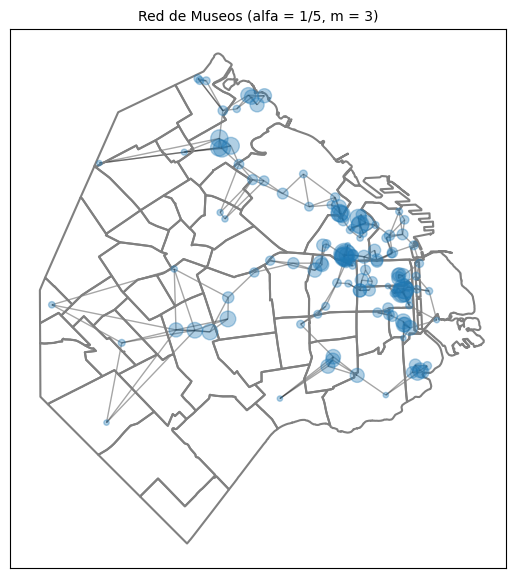

In [9]:
# VISUALIZACIÓN del punto 3a)

G = nx.from_numpy_array(Aa) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

def agregar_nodos(lista_pagerank): #funcion que asigna el tamaño del nodo a cada museo según su pagerank.
    lista_nodos = []
    i = 0
    while i < len(lista_pagerank):
        lista_nodos.append((lista_pagerank[i])*10000) #sin el 10000 no se verían los nodos.
        i+=1
    return lista_nodos

node_sizes = agregar_nodos(pageranks) #lista con el tamaño de cada nodo. Para graficar.

fig, ax = plt.subplots(figsize=(7, 7)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
ax.set_title("Red de Museos (alfa = 1/5, m = 3)", fontsize=10) # Agregamos un titulo al grafico
nx.draw_networkx(G,G_layout,ax=ax,node_size= node_sizes, alpha = 0.35, with_labels=False) # Graficamos los museos

Este gráfico muestra el Pagerank de cada museo cuando alfa = 1/5 y m = 3. Aquí podemos observar la existencia de ciertos museos centrales (que luego llamaremos museos núcleo) que tienen un pagerank notoriamente mayor que los museos perisfericos que los rodean. Esta cantidad de conexiones acentúa la distancia de los museos entre sí, es decir, no hay museos del norte de la provincia con conexión directa con algún museo del sur.

In [10]:
#punto 3b) Calculo la matriz de adyacencia para cada m dado
m1 = 1
A1 = construye_adyacencia(D,m1)

m2 = 3
A2 = construye_adyacencia(D,m2)

m3 = 5
A3 = construye_adyacencia(D,m3)

m4 = 10
A4 = construye_adyacencia(D,m4)

alfa = 1/5

def pagerank(A):
    return calcula_pagerank(A,alfa)

p1 = pagerank(A1) # calculamos el pagerank para cada matriz hallada anteriormente
p3 = pagerank(A2)
p5 = pagerank(A3)
p10 = pagerank(A4)

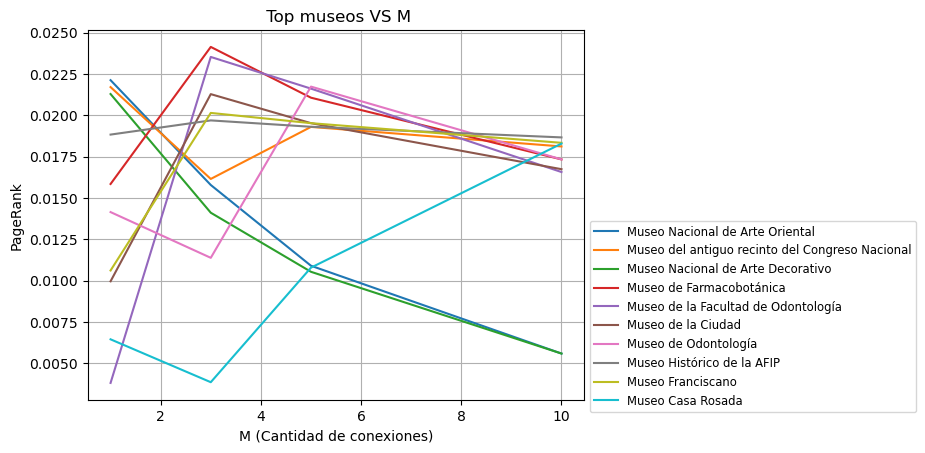

In [11]:
# VISUALIZACIONES punto 3b)

relacionesm = [1,3,5,10] #las conexiones que quiero graficar

rankings = [p1,p3,p5,p10] #Pageranks según la cantidad de conexiones


lista_museos= sortmuseos(rankings) #lista con todos los museos que estuvieron en el top 3 para algún m
for i in range(0,(len(lista_museos))):
    plt.plot(relacionesm, [p1[lista_museos[i]],p3[lista_museos[i]],p5[lista_museos[i]],p10[lista_museos[i]]] , label=f"{museos.iloc[lista_museos[i]]['name']}") # armo el gráfico con los museos con mayor puntaje de cada pagerank armado

plt.xlabel("M (Cantidad de conexiones)")
plt.ylabel("PageRank")
plt.title(" Top museos VS M")
plt.legend(bbox_to_anchor=(1, 0.5), fontsize='small')
plt.grid(True)
plt.show()

En el gráfico "Top Museos vs M" podemos observar la variación del pagerank de aquellos museos que tuvieron puntaje alto, siendo en algún momento parte de los 3 mejores, con alfa = 1/5 a medida que varía M desde 1 a 10.
Al estar trabajando con un alfa pequeño, las conexiones entre los museos tienen más peso porque el flujo de las personas es menos azaroso y se basa en los movimientos predestinados. Notamos que entre 1 y 3 conexiones hay una mayor dispersión de los puntajes, mientras que a medida que la cantidad de conexiones aumenta, los top museos tienden a un pagerank cercano a 0.0175.   


A medida que aumenta M se pueden notar dos outliers: Museo Nacional de Arte Oriental y Museo Nacional de Arte Decorativo. Ambos comenzaron con el pagerank más alto, pero a medida que aumenta la cantidad de conexiones su puntaje disminuye notoriamente. Esto podría suceder porque hay otros museos que resultan ser más céntricos, que acaparan nuevas conexiones y obtienen mayor pagerank, disminuyendo el valor de aquellos museos que los apuntan (porque puede suceder que el flujo no sea recíproco).

El pagerank de los museos perisfericos disminuye. Como estos apuntan a los centrales, los centrales reciben conexiones de menor valor y así disminuyen su pagerank. En el gráfico se ve que al aumentar las conexiones a 10, se nota una caída en el pagerank de todos los top museos.

Lo mencionado en este texto se confirma en los mapas que aparecen a continuación.

Text(0.5, 1.0, 'Red de Museos (alfa = 1/5, m = 10)')

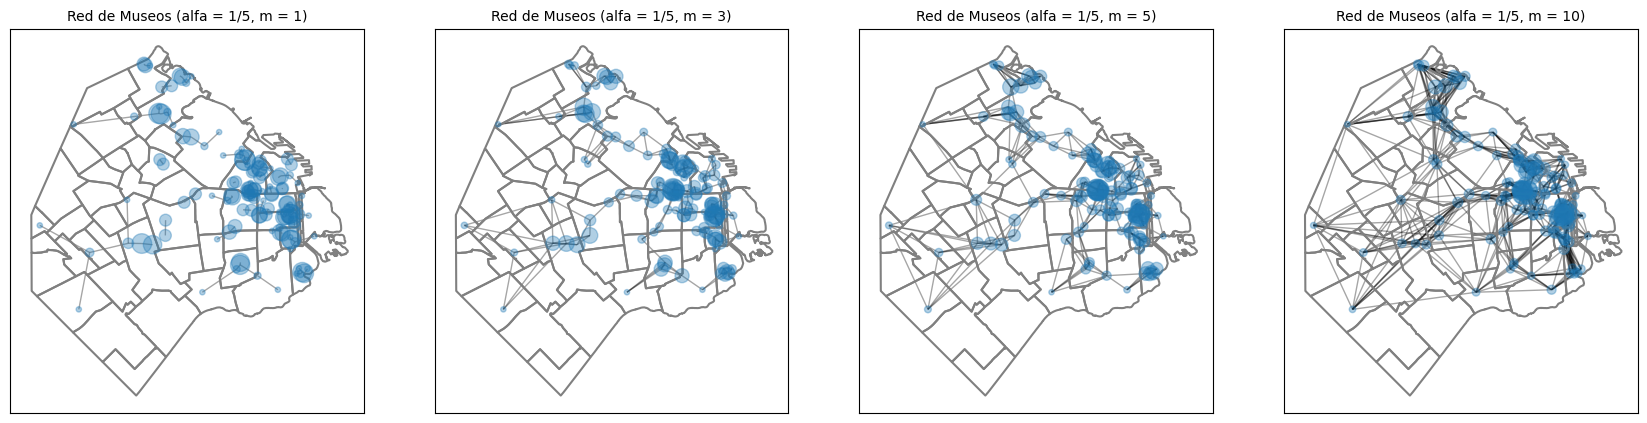

In [12]:
#VISUALIZACIONES. MAPAS PARA CADA M

G1 = nx.from_numpy_array(A1)
G3 = nx.from_numpy_array(A2)
G5 = nx.from_numpy_array(A3)
G10 = nx.from_numpy_array(A4) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

node_sizes1 = agregar_nodos(p1) #lista con el tamaño de cada nodo. Para graficar.
node_sizes2 = agregar_nodos(p3)
node_sizes3 = agregar_nodos(p5)
node_sizes4 = agregar_nodos(p10)

fig, ax = plt.subplots(1,4,figsize=(21, 7)) # Visualización de la red en el mapa
for i in range (0,4):
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax[i]) # Graficamos Los barrios
nx.draw_networkx(G1,G_layout,ax=ax[0],node_size = node_sizes1,alpha = 0.35, with_labels=False) # Graficamos los museos
ax[0].set_title("Red de Museos (alfa = 1/5, m = 1)", fontsize=10) # Agregamos título
nx.draw_networkx(G3,G_layout,ax=ax[1],node_size = node_sizes2,alpha = 0.35, with_labels=False)
ax[1].set_title("Red de Museos (alfa = 1/5, m = 3)", fontsize=10)
nx.draw_networkx(G5,G_layout,ax=ax[2],node_size = node_sizes3,alpha = 0.35, with_labels=False)
ax[2].set_title("Red de Museos (alfa = 1/5, m = 5)", fontsize=10)
nx.draw_networkx(G10,G_layout,ax=ax[3],node_size = node_sizes4,alpha = 0.35, with_labels=False)
ax[3].set_title("Red de Museos (alfa = 1/5, m = 10)", fontsize=10)

Al tener un alfa bajo, los visitantes tienden a seguir las conexiones basados en el peso del link, moviendose en su mayoría a unos pocos museos centrales muy visitados. Eso se ve reflejado en la pérdida de peso de los museos céntricos y ligeramente más pequeños ubicados entre medio de los más importantes en el primer mapa. A medida que aumenta el numero de conexiones, es más probable que aparezca una conexión directa entre un museo céntrico pequeño con uno céntrico grande, captando los visitantes del primero.   


En el primer mapa, donde hay una sola conexión, se pueden ver varios "circuitos cerrados" con sus museos núcleo (es decir, un museo de mayor tamaño rodeado de otros más pequeños). Observamos que en los siguientes dos mapas, los museos núcleo de los que antes fueron circuitos cerrados están conectados al centro a través de un museo poco relevante. Hay un leve decrecimiento de relevancia en estos museos núcleo. En el ultimo mapa la diferencia entre los museos que fueron núcleo y los que eran parte de su circuito cerrado es casi imperceptible, lo que apoya a nuestra hipótesis inicial.

Es interesante observar que en el norte hay un núcleo que mantiene la relevancia inicial. Creemos que esto sucede al no estar conectado directamente con el centro.

In [13]:
#punto 3c) Calculamos el pagerank según cada alfa
relacion = 5 # 5 conexiones
Ac = construye_adyacencia(D,relacion)

alfa1 = 6/7
alfa2 = 4/5
alfa3 = 2/3
alfa4 = 1/2
alfa5 = 1/3
alfa6 = 1/5
alfa7 = 1/7
a1 = calcula_pagerank(Ac,alfa1)
a2 = calcula_pagerank(Ac,alfa2)
a3 = calcula_pagerank(Ac,alfa3)
a4 = calcula_pagerank(Ac,alfa4)
a5 = calcula_pagerank(Ac,alfa5)
a6 = calcula_pagerank(Ac,alfa6)
a7 = calcula_pagerank(Ac,alfa7)

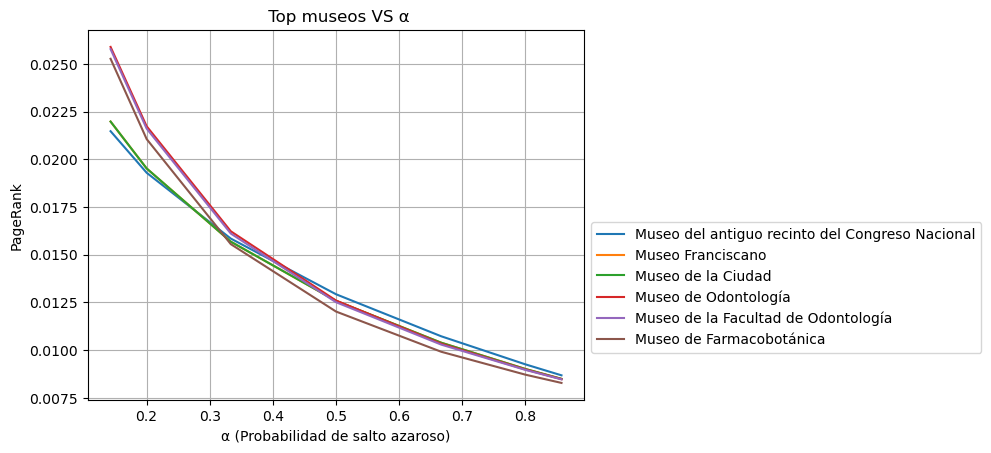

In [14]:
# VISUALIZACIONES punto 3c)

alphas_valor = [alfa1,alfa2,alfa3,alfa4,alfa5,alfa6,alfa7] # cada valor de alfa dado
alphas_rankings =[a1, a2, a3, a4, a5, a6, a7] # pageranks segun cada alfa dado

lista_museos= sortmuseos(alphas_rankings) #lista con todos los museos que estuvieron en el top3 para algún α
#top 3 museos para cada α
for i in range(0,(len(lista_museos))):
    plt.plot(alphas_valor, [a1[lista_museos[i]],a2[lista_museos[i]],a3[lista_museos[i]],a4[lista_museos[i]],a5[lista_museos[i]],a6[lista_museos[i]],a7[lista_museos[i]]] , label=f"{museos.iloc[lista_museos[i]]['name']}") # armamos el gráfico con los museos con mayor puntaje de cada pagerank armado

plt.xlabel("α (Probabilidad de salto azaroso)")
plt.ylabel("PageRank")
plt.title(" Top museos VS α")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.show()


Alfa está definido como la probabilidad de movimientos aleatorios de los visitantes entr los museos. En este gráfico, es posible obervar que al aumentar alfa, todos los museos disminuyen su pagerank siguiendo comportamientos similares. Un alfa igual a 1 significa que todas las conexiones existentes no tienen peso, por lo que los museos tienen todos igual puntaje y así el pagerank pierde relevancia. Por eso vemos una convergencia del pagerank a 0 en las funciones de cada museo cuando alfa tiende a 1.  


Notamos que la cantidad de museos dentro del gráfico es menor al del gráfico "Top museos vs M". Esto podría deberse a que las conexiones se mantienen estables y son la fuente de valor, y que si bien los museos perifericos al tender alfa a 1 aumenta su relevancia porcentual, nominalmente siguen valiendo menos, y al perder pagerank los museos centrales, también lo pierden los museos perifericos. Entonces nunca sucede que los museos perifericos tengan mayor valor que uno central. Esto hace que el top 3 museos con mayor pagerank se mantenga dentro de todo estable.

Text(0.5, 1.0, 'Red de Museos (alfa = 1/7, m = 5). Azar disminuido')

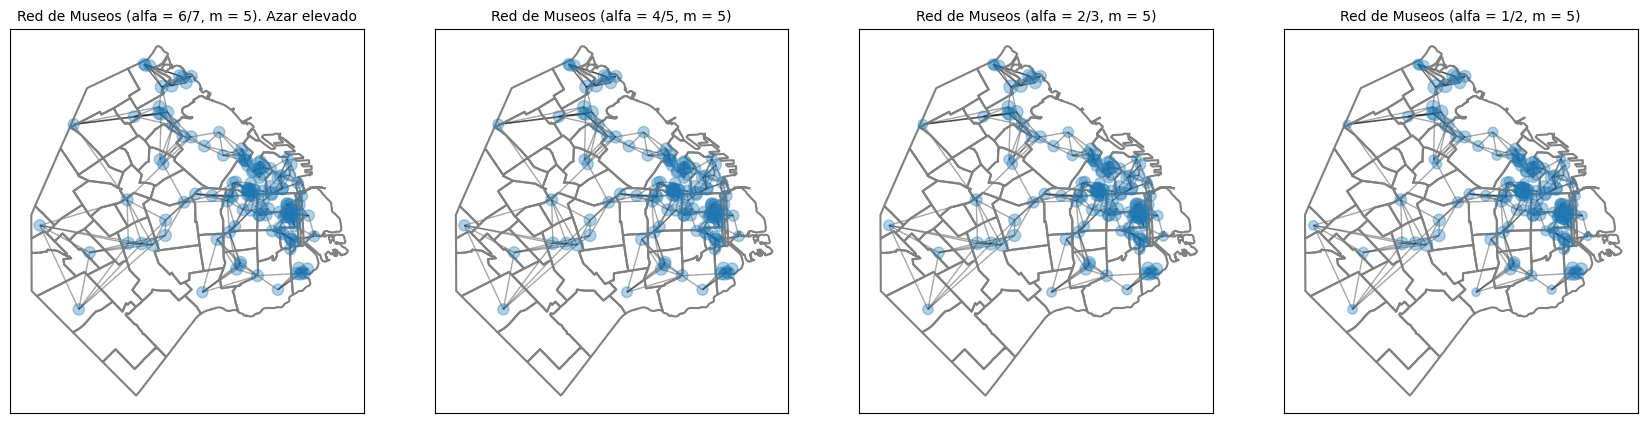

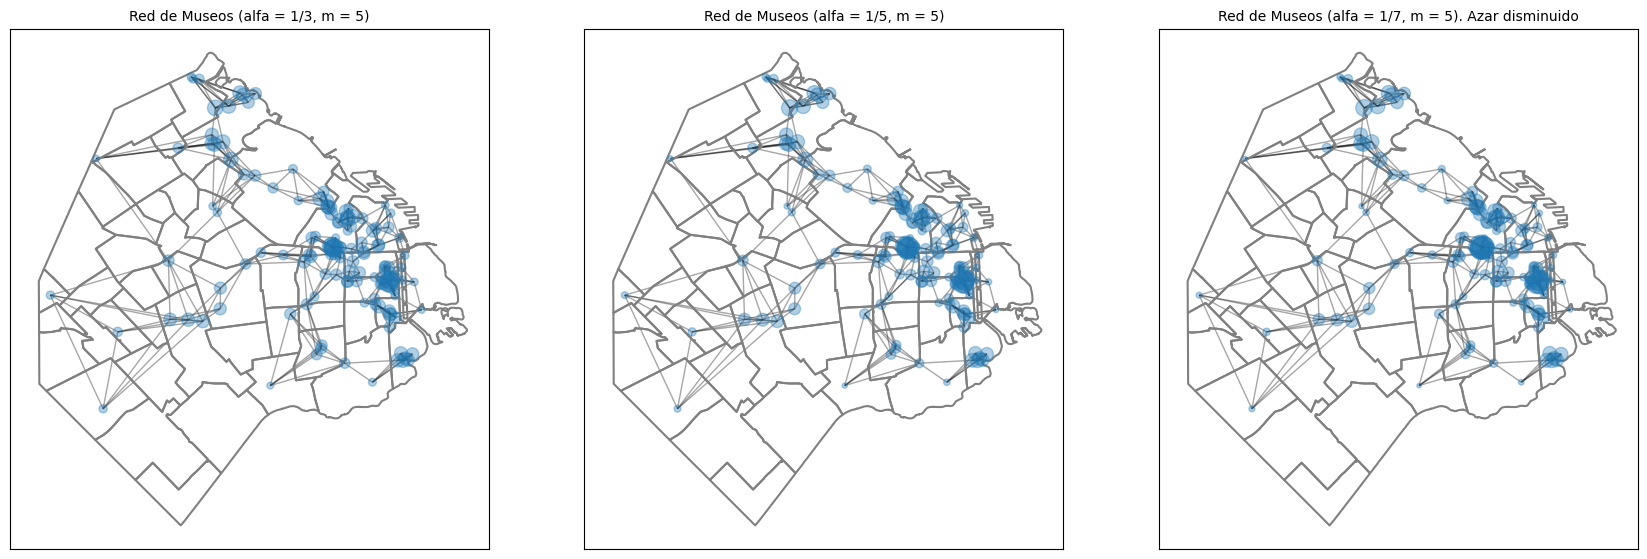

In [15]:
#VISUALIZACIONES. Mapa según cada α

G = nx.from_numpy_array(Ac) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

node_sizes1 = agregar_nodos(a1) #lista con el tamaño de cada nodo. Para graficar.
node_sizes2 = agregar_nodos(a2)
node_sizes3 = agregar_nodos(a3)
node_sizes4 = agregar_nodos(a4)
node_sizes5 = agregar_nodos(a5)
node_sizes6 = agregar_nodos(a6)
node_sizes7 = agregar_nodos(a7)

fig, ax = plt.subplots(1,4,figsize=(21, 7)) # Visualización de la red en el mapa
for i in range (0,4):
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax[i]) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax[0],node_size = node_sizes1,alpha = 0.35, with_labels=False) # Graficamos los museos
ax[0].set_title("Red de Museos (alfa = 6/7, m = 5). Azar elevado", fontsize=10)
nx.draw_networkx(G,G_layout,ax=ax[1],node_size = node_sizes2,alpha = 0.35, with_labels=False)
ax[1].set_title("Red de Museos (alfa = 4/5, m = 5)", fontsize=10)
nx.draw_networkx(G,G_layout,ax=ax[2],node_size = node_sizes3,alpha = 0.35, with_labels=False)
ax[2].set_title("Red de Museos (alfa = 2/3, m = 5)", fontsize=10)
nx.draw_networkx(G,G_layout,ax=ax[3],node_size = node_sizes4,alpha = 0.35, with_labels=False)
ax[3].set_title("Red de Museos (alfa = 1/2, m = 5)", fontsize=10)

fig, ax = plt.subplots(1,3,figsize=(21, 7)) # Visualización de la red en el mapa
for i in range (0,3):
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax[i]) # Graficamos Los barrios
nx.draw_networkx(G,G_layout,ax=ax[0],node_size = node_sizes5,alpha = 0.35, with_labels=False) # Graficamos los museos
ax[0].set_title("Red de Museos (alfa = 1/3, m = 5)", fontsize=10)
nx.draw_networkx(G,G_layout,ax=ax[1],node_size = node_sizes6,alpha = 0.35, with_labels=False)
ax[1].set_title("Red de Museos (alfa = 1/5, m = 5)", fontsize=10)
nx.draw_networkx(G,G_layout,ax=ax[2],node_size = node_sizes7,alpha = 0.35, with_labels=False)
ax[2].set_title("Red de Museos (alfa = 1/7, m = 5). Azar disminuido", fontsize=10)



Al aumentar el azar, los pageranks tienden a igualarse porque todos tienen una probabildad similar de recibir visitantes.  


Para los alfas más pequeños, los museos mejor conectados disminuyen su pagerank pero lo conservan mejor que los perifericos. Esto sucede porque al aproximarse alfa a cero, es más probable que los visitantes se limiten a seguir las conexiones de su museo, disminuyendo el pagerank de los perifericos, porque tienen pocos museos apuntando hacia ellos. Al perder pagerank los perifericos, estos aportan menos valor al apuntar a los centrales, y por eso los centrales también pierden.


## Punto 4:
El ejercicio consta de probar que $ v = B^{-1} w $ .  

Para ello, asumimos que la matríz B es inversible porque el ejercicio explícitamente utiliza su inversa.

Multiplicamos ambos lados por la matríz B:
$$Bv = B *B⁻¹ w  $$


Utilizando la propiedad de la matríz inversa que expresa $A *A^{-1} = Id$:  

$$B *B^{-1} = Id \Rightarrow Bv = w$$

Como $B = \sum_{k=0}^{r-1}C^k$ ,

notamos que la matríz $B$ muestra la sumatoria de las potencias de la matríz $C$ (quienes representan la probabilidad de cambio de distribución sobre el total de museos),  
las cuales multiplicadas por $v$ (la distribución inicial de las personas en los museos) representan los distintos estados de distribución  de las personas en los museos.

Entonces:
$$Bv  = (C^0 + C^1 + C^2 +...+C^{r-1}) v \\ \Rightarrow
Bv  = C^0 v+ C^1 v+ C^2 v+...+C^{r-1} v $$

Por esto, vemos que Bv estima el numero total de visitas de cada museo, que es igual a lo que $w$ representa.
Es decir:
$Bv = w$
#### $$\therefore v = B^{-1} w $$

## Punto 5:

In [16]:

ruta = r"c:\Users\Julia\OneDrive\Escritorio\FACU\ALC\TP1\visitas.txt" #editar esta variable con el path si es necesario
w_csv = np.loadtxt(ruta)
 # visitas totales de cada museo

r = 3
C = calcula_matriz_C_continua(D)
B = calcula_B(C,r)

print(calcula_v(w_csv,B))

50000.0


c:\Users\Julia\OneDrive\Escritorio\FACU\ALC\TP2\TP2_FINAL\template_funciones_2.py:152: RuntimeWarning: divide by zero encountered in divide
  F = 1/D


## Punto 6:

In [17]:
# Calculamos el num de condición de B a partir de la función armada, y a partir de eso, estimamos la cota para el error de estimación de v.
error = 0.05 #error del 5%

cond_B = num_condicion(B)
B2_error = cond_B* error * 100 # multiplicamos por 100 para pasar a porcentaje %
print(cond_B) # número de condición de B
print(B2_error) # cota para el error de estimación de v (en porcentaje). El error de estimación de v va a ser menor o igual a ese resultado

5.051771176665007
25.258855883325033


# Extras

Para graficar la red con un conjunto de puntajes (como el Page Rank)

{0: Text(4924405.086723215, 6160838.106023658, ''),
 1: Text(4917216.80489522, 6166701.553530234, ''),
 2: Text(4924486.298584606, 6161409.256658559, ''),
 3: Text(4921922.052887296, 6164690.544542129, ''),
 4: Text(4920636.67547965, 6165640.199444978, ''),
 5: Text(4925338.320928778, 6162016.528710163, ''),
 6: Text(4922856.100832731, 6163868.567721188, ''),
 7: Text(4922641.894255253, 6162355.100129171, ''),
 8: Text(4917938.7521918025, 6168273.372961773, ''),
 9: Text(4924683.52693892, 6158996.617208998, ''),
 10: Text(4925725.9600755945, 6160896.846339954, ''),
 11: Text(4922075.10183836, 6164294.738410278, ''),
 12: Text(4926038.146946977, 6159721.190876993, ''),
 13: Text(4925200.592014585, 6161503.005610317, ''),
 14: Text(4925229.168803978, 6160973.145341254, ''),
 15: Text(4924875.410406244, 6161061.981187101, ''),
 16: Text(4924474.294424794, 6161547.549492302, ''),
 17: Text(4923553.755484842, 6163571.336254905, ''),
 18: Text(4924615.955668659, 6160843.2491330765, ''),
 19:

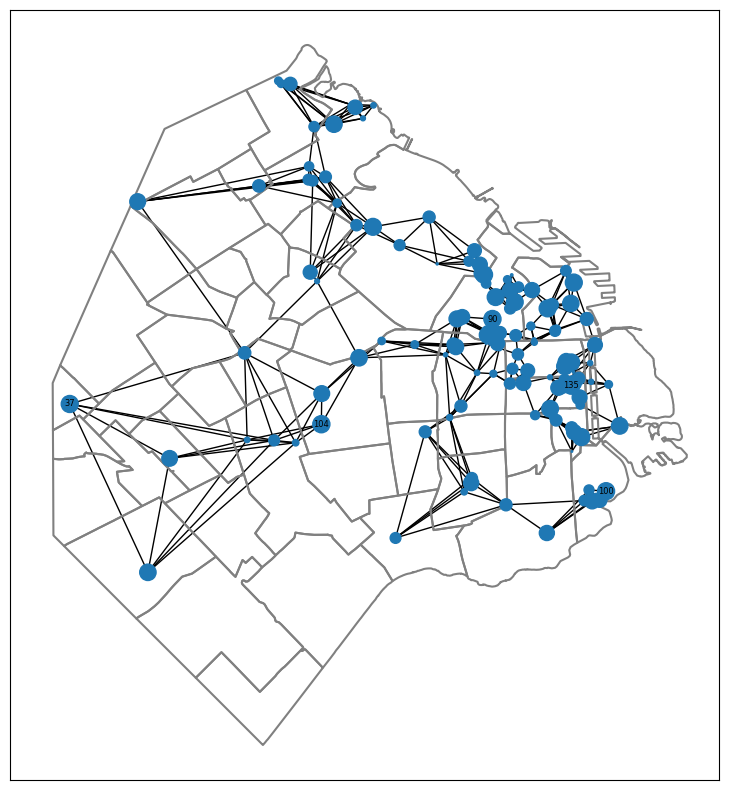

In [18]:
factor_escala = 1e4 # Escalamos los nodos 10 mil veces para que sean bien visibles
fig, ax = plt.subplots(figsize=(10, 10)) # Visualización de la red en el mapa
barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax) # Graficamos Los barrios
pr = np.random.uniform(0,1,museos.shape[0])# Este va a ser su score Page Rank. Ahora lo reemplazamos con un vector al azar
pr = pr/pr.sum() # Normalizamos para que sume 1
Nprincipales = 5 # Cantidad de principales
principales = np.argsort(pr)[-Nprincipales:] # Identificamos a los N principales
labels = {n: str(n) if i in principales else "" for i, n in enumerate(G.nodes)} # Nombres para esos nodos
nx.draw_networkx(G,G_layout,node_size = pr*factor_escala, ax=ax,with_labels=False) # Graficamos red
nx.draw_networkx_labels(G, G_layout, labels=labels, font_size=6, font_color="k") # Agregamos los nombres

# Resolucion del TP 2

## Punto 1:
### A:
Para poder ver que el vector de 1 es autovector de las matrices R y L, utilizaremos la propiedad general de autovectores : $Av = \lambda v$

1 A i)
-----
$\bullet$ Si 1 es autovector de L, entonces:
$$Lv = \lambda v$$
$$L*1 = \lambda 1$$
Sabiendo que L = K - A donde L es la matríz laplaciana simétrica y semidefinida positiva; K es la matríz diagonal donde $K_{ii} = k_i = \sum_{j=1}^{n}{A_{ij}}$; y A simétrica:  

$$(K - A) * 1 = \lambda 1$$
$$ K*1 - A*1 = \lambda 1$$

Multiplicar por el vector de 1 es lo mismo que calcular la suma de los elementos de la fila de cada matríz.

$$
K*1 =\begin{bmatrix}
k_1 + 0 + ... + 0 \\
... \\
0 + ... + 0 + k_n
\end{bmatrix} =
\begin{bmatrix}
k_1\\
... \\
k_n
\end{bmatrix}
$$
y por la definición de $k_i$
$$
K*1 =
 \begin{bmatrix}
\sum_{j=1}^{n}A_{1j}\\
... \\
\sum_{j=1}^{n}A_{nj}
\end{bmatrix}
$$
por otro lado, la matríz A:

$$
A*1 =\begin{bmatrix}
A_{11} + A_{12} + ... + A_{1n} \\
... \\
A_{n1} + A_{n2}... + A_{nn}
\end{bmatrix} =
 \begin{bmatrix}
\sum_{j=1}^{n}A_{1j}\\
... \\
\sum_{j=1}^{n}A_{nj}
\end{bmatrix}
$$
Entonces:
$$
K*1 - A*1 = \begin{bmatrix}
\sum_{j=1}^{n}A_{1j}\\
... \\
\sum_{j=1}^{n}A_{nj}
\end{bmatrix} -
\begin{bmatrix}
\sum_{j=1}^{n}A_{1j}\\
... \\
\sum_{j=1}^{n}A_{nj}
\end{bmatrix} = 0
$$
Entonces
$$ K*1 - A*1 = \lambda 1$$
$$ 0 = \lambda 1$$
Y solo es posible si $\lambda = 0$ es el autovalor asociado a 1 como autovector de L.

Al ser el autovalor asociado 0, el vector de 1 pertenece al núcleo de L. Que pertenezca al núcleo significa que no hay ningún corte y todos pertenecen a un mismo grupo. Es por esto que se toma el segundo autovalor más chico (dado que los autovalores de L son mayores o iguales a cero, definido en la presentación del tp)

1 A ii)
---------------------------------------
$\bullet$ Si 1 es autovector de R, entonces:

$$ R1 = \lambda 1 $$

Sabiendo que R = A - P, donde $P_{ij} = \frac{1}{2E}* k_i * k_j$ y además $2E= \sum_{i=1}^{n} \sum_{j=1}^{n} A_{ij}$ :    
$$
A*1 - P*1 = \begin{bmatrix}
\sum_{j=1}^{n}A_{1j}\\
... \\
\sum_{j=1}^{n}A_{nj}
\end{bmatrix} -
\begin{bmatrix}
\sum_{j=1}^{n}P_{1j}\\
... \\
\sum_{j=1}^{n}P_{nj}
\end{bmatrix}
$$

Veamos quien es $P*1$:

$$
P*1 =\begin{bmatrix}
\sum_{j=1}^{n}P_{1j}\\
... \\
\sum_{j=1}^{n}P_{nj}
\end{bmatrix} =
\begin{bmatrix}
\sum_{j=1}^{n}\frac{1}{2E}* k_1 * k_j\\
... \\
\sum_{j=1}^{n}\frac{1}{2E}* k_n * k_j
\end{bmatrix}
$$

Como $\frac{1}{2E}$ es constante y de los k los únicos que varían dentro de la sumatoria son los que contienen a j como subíndice, lo puedo reescribir de esta manera:
$$
P*1 =\begin{bmatrix}
\frac{1}{2E}* k_1 * \sum_{j=1}^{n}k_j\\
... \\
\frac{1}{2E}* k_n * \sum_{j=1}^{n} k_j
\end{bmatrix}
$$

Por definición de K, usando que  $k_i = \sum_{j=1}^{n}{A_{ij}}$ :    
$$
P*1 =\begin{bmatrix}
\frac{1}{2E}* \sum_{j=1}^{n}A_{1j}* \sum_{j=1}^{n}\sum_{f=1}^{n}{A_{jf}}\\
... \\
\frac{1}{2E}* \sum_{j=1}^{n}A_{nj}* \sum_{j=1}^{n}\sum_{f=1}^{n}{A_{jf}}
\end{bmatrix}
$$

Además, sabemos que $2E = \sum_{j=1}^{n}\sum_{f=1}^{n}{A_{jf}} $, por lo tanto:

$$
P*1 =\begin{bmatrix}
\frac{1}{2E}* \sum_{j=1}^{n}A_{1j}* 2E\\
... \\
\frac{1}{2E}* \sum_{j=1}^{n}A_{nj}* 2E
\end{bmatrix} =
\begin{bmatrix}
\sum_{j=1}^{n}A_{1j}\\
... \\
\sum_{j=1}^{n}A_{nj}
\end{bmatrix}
$$

Entonces, obtenemos que $R*1 = A*1 - P*1 = \lambda 1$

$$
A*1 - P*1 = \begin{bmatrix}
\sum_{j=1}^{n}A_{1j}\\
... \\
\sum_{j=1}^{n}A_{nj}
\end{bmatrix} -
\begin{bmatrix}
\sum_{j=1}^{n}A_{1j}\\
... \\
\sum_{j=1}^{n}A_{nj}
\end{bmatrix} = 0
$$
$$0 = \lambda 1$$
Y sólo es posible si $\lambda = 0$ es el autovalor asociado a 1 como autovector de R.

Observamos también que, al igual que con la matríz L, como su autovalor asociado es 0, 1 pertenece al núcleo de R. Que pertnenezca al núcleo significa que no hay ningún corte y todos pertenecen a un mismo grupo.


### 1B:
Veamos que si L tiene dos autovectores $v_1$ y $v_2$ asociados a autovalores $\lambda _1 \neq \lambda _2$ entonces $v_1^t v_2 = 0$:

usando la propiedad de los autovectores: $Av = \lambda v$

$$\begin{cases}
Lv_1 = \lambda _1 v_1 \\
Lv_2 = \lambda _2 v_2
\end{cases}$$

Analicemos solo la primera ecuación:
$$Lv_1 = \lambda _1 v_1$$

Multiplico por $v_2^t$ ambos lados:
$$v_2^tLv_1 = v_2^t \lambda _1 v_1$$

como L es simétrica, vale que:

$$(Lv_2)^tv_1 = \lambda _1 v_2^t v_1$$

reemplazando con la segunda ecuación:

$$(\lambda _2 v_2)^t v_1 = \lambda _1 v_2^t v_1$$

$$\lambda _2 v_2^t v_1 - \lambda _1 v_2^t v_1 = 0$$
$$ v_2^t v_1 (\lambda _2 - \lambda _1 ) = 0$$

Como $\lambda _1 \neq \lambda _2$ , entonces se debe cumplir que $v_2^t v_1 = 0$

Además, es interesante observar que si multiplicamos la segunda ecuación por $v_1^t$ se llega de la misma forma a que $v_1^t v_2 = 0$, y también notamos que la demostración sólo precisa que la matríz sea simétrica, sin depender de los autovalores; por lo que esta demostración también se cumple para la matríz R.

Justificación de que R es simétrica:

Sabemos que R = A - P, donde A es simétrica por definición, y P está compuesta por $P_{ij} = \frac{1}{2E}* k_i * k_j$ donde $k_i; k_j$ corresponden a los elementos de la diagonal de la matriz k. 

P es simétrica si $P_{ij} = P_{ji}$

$$P_{ij} = (\frac{1}{2E}* k_i * k_j)$$
$$P_{ji} = (\frac{1}{2E}* k_j * k_i)$$
Se verifica que P es simétrica, sabiendo que E es el total de nodos de A, por lo que es un número constante
$(\frac{1}{2E}* k_i * k_j) = (\frac{1}{2E}* k_j * k_i)$

Como A y P son simétricas, la suma o resta entre matrices simétricas también es simétrica (propiedad), ya que para las posiciones $A_{ij}; A_{ji}$ (las cuales tienen el mismo valor entre sí), les estoy restando, respectivamente, $P_{ij}; P_{ji},$ las cuales también tienen el mismo valor entre sí.

### 1C:
Probemos que si v es autovector de autovalor $\lambda \neq 0$ de R o L, entonces $\sum _i v_i$ = 0.

$\bullet$ Para L:
$$Lv = \lambda v$$

Como probamos en el ejercicio 1a, las filas de L suman 0 al ser multiplicadas por el vector de unos:

$$
L \begin{bmatrix}
1\\
... \\
1
\end{bmatrix} = 0
$$

Sabiendo esto, multiplico por el vector $1^t$:
$$1^t Lv = (L1)^tv = 1 ^t \lambda v$$

Como L es simétrica:
$$(L1)^tv= L1v = 1 ^t \lambda v = 0 $$

como  $\lambda \neq 0$ , entonces $ 1 v = 0 $ es decir $\sum _i v_i = 0$

$\bullet $ Como la matríz R también es simétrica y cumple que
$
R \begin{bmatrix}
1\\
... \\
1
\end{bmatrix} = 0
$, la demostración es idéntica a la anterior.


## Ejercicio 2:
### 2A:
Demostremos que los autovalores de $M + \mu I$ son $ \gamma _i = \lambda _i + \mu$ y que su vector asociado es $v_i$ quien es el mismo autovector asociado al autovalor $\lambda _i$ para la matríz M, sabiendo que M es diagonalizable.

Como M es diagonalizable, puede ser escrita como $$M = CDC^{-1}$$
Donde C es la matríz con sus autovectores como columnas, y D la matríz diagonal que contiene sus autovalores.
$$M + \mu I = C  D  C^{-1} + \mu I$$
Recordando que $\mu$ es escalar,
Vale que $\mu I =  \mu C I C^{-1} = C(\mu I) C^{-1} \Rightarrow$
$$M + \mu I = C D C^{-1} + C (\mu I)C^{-1}$$
Y se puede reescribir como:
$$M + \mu I = C ( D + \mu I ) C^{-1}$$

Y por propiedades de las matrices diagonalizables, sabemos que los elementos de la diagonal de $D + \mu I $ contienen los autovalores mientras que C contiene los autovectores de la matriz $M + \mu I$.

Como los elementos de $D + \mu I$ (autovalores de $M + \mu I$) pueden ser escritos como $ \gamma _i = \lambda _i + \mu$, y C es el mismo, queda probado que su vector asociado $v_i$ es el mismo autovector asociado al autovalor $\lambda _i$ para la matríz M.

Por último, si todos los autovalores de $M + \mu I$ son $\neq$ 0 ($ \gamma _i = \lambda _i + \mu \neq $ 0), entonces como el determinante de una matriz cuadrada es la multiplicación de sus autovalores, det($M + \mu I$) $\neq$ 0, y por lo tanto $M + \mu I$ es inversible. Demostración de eso:

Tomo A = $M + \mu I$

Consideremos el polinomio característico de A dado por
$\chi_A(\lambda) = \det(\lambda I - A)$.

Como ($ \lambda_1,\lambda_2,\dots,\lambda_n $ ) son los autovalores de A (repetidos según su multiplicidad), sabemos que

$\chi_A(\lambda) = (\lambda - \lambda_1)(\lambda - \lambda_2)\cdots(\lambda - \lambda_n)$.

Luego, evaluando en ( $ \lambda = 0 $ ):

$\chi_A(0) = \det(-A) = (-1)^n \prod_{i=1}^n \lambda_i $.

Y como además ( $ \det(-A)=(-1)^n\det(A) $ ), concluimos

$\det(A) = \prod_{i=1}^n \lambda_i $

Una vez demostrada, es evidente que una matriz es invertible si y sólo si todos sus autovalores son distintos de 0.








### 2B:
Considerando $ \mu $ > 0 y L el Laplaciano, probemos que $ L + \mu I $ es inversible.

Sabemos que L es simétrica y semidefinida positiva y sus autovalores $ \geq 0$. Además, en el ejercicio 1a) probamos que 0 es autovalor de L con el vector de 1 su autovector asociado; es decir que la dimensión de su nucleo es > 0 y por lo tanto L no es inversible.

Ahora bien, como L es una matríz simétrica y $\mu I $ es la matríz identidad multiplicada por una constante > 0 (diagonal y por lo tanto simétrica) se cumple que si $\lambda$ es autovalor de L, entonces $\lambda + \mu$ es autovalor de $L + \mu I$ y su autovector asociado es el mismo. Por ejemplo, sabemos que cuando $\lambda = 0$, el autovalor de la matríz $ L + \mu I$ es $ \mu $ y su autovector asociado es el vector de 1.

Sabemos que $\lambda \geq 0$ y $\mu > 0$ , entonces $\lambda + \mu > 0$ y esto implica que todo autovalor de la matríz $L + \mu I$ es mayor a 0. Así, queda probado que **$L + \mu I$ es inversible**.

Ahora, probemos que aplicando el método de la potencia, $ (L + \mu I) ^{-1}$ converge al autovector de autovalor más chico.

Usaremos que $L + \mu I $ es inversible y sabiendo que en general la relación entre los autovalores de una matríz y su inversa es:
$$Av = \lambda v \Leftrightarrow A^{-1}v = \frac{1}{\lambda} v $$

Los autovalores de $L + \mu I$ son $ \gamma _i = \lambda _i + \mu, (i= 1, 2, ..., n)$, entonces por la relación anterior los autovalores de $(L + \mu I) ^{-1}$ son $\frac{1}{\lambda _i + \mu}$.

Al aplicar el método de la potencia, $(L + \mu I) ^{-1}$ converge a la dirección de su autovector dominante. Es decir, tiende al autovector cuyo autovalor es mayor:
$$ \gamma _{max} =\frac{1}{|min(\lambda _i + \mu)|} = \frac{1}{\mu}$$

Debido a que $0 \leq \lambda _1 \leq \lambda _2 \leq ... \leq \lambda _n \Rightarrow |min(\lambda _i + \mu)| = 0 + \mu = \mu$ .

Usando la relación entre los autovectores de la matríz y su inversa:
$$(L + \mu I)^{-1} v = \frac{1}{\mu} v \Leftrightarrow (L + \mu I) v = \mu v$$

Como vimos anteriormente, el autovector asociado a $\gamma = \mu $ para la matríz $L + \mu I$ es el mismo que $\lambda = 0 $ para L, que hace referencia al vector de 1.

Entonces, concluimos que al aplicar el método de la potencia a $(L + \mu I)^{-1}$ converge al vector de 1 que es el autovector de autovalor más chico $(\mu)$

Además, como la dimensión del nucleo de L es 1, sabemos que el vector de 1 es el unico autovector con autovalor $\mu$.


### 2C:
siendo M simétrica, probaremos que la matriz $\widetilde {M} = M - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1}$ tiene los mismos autovectores que M, pero el autovalor asociado a $v_1$ es 0.

-  Para $v_1$ tenemos:
$$\widetilde {M}v_1 = (M - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1})v_1$$
$$\widetilde {M}v_1 = Mv_1 - \lambda_1 \frac{v_1 v_1^t v_1}{v_1^t v_1}$$

Usando que $Mv_1 = \lambda _1 v_1$:

$$\widetilde {M} v_1 = \lambda _1 v_1 - \lambda_1 \frac{v_1 (v_1^tv_1)}{v_1^t v_1}$$
$$\widetilde {M} v_1 = \lambda _1 v_1 - \lambda_1 v_1$$
$$\widetilde {M} v_1 = 0 $$

Por lo tanto, $v_1$ es autovector de $\widetilde {M}$ con autovalor 0

- Ahora, veamos que $\widetilde {M}$ tiene los mismos autovectores que M para todo $v_i, i \neq 1$:
 $$\widetilde {M}v_i = (M - \lambda_1 \frac{v_1 v_1^t}{v_1^t v_1})v_i$$

 $$\widetilde {M}v_i = M v_i - \lambda_1 \frac{v_1 v_1^tv_i}{v_1^t v_1}$$

 Como $v_1$ y $v_i$ son ortogonales, $ <v_1^tv_i >  = 0 $, entonces:

$$\widetilde {M}v_i = M v_i - 0$$

$$ \therefore \widetilde {M}v_i = M v_i, \forall i \neq 1$$

C:\Users\Julia\AppData\Local\Temp\ipykernel_30896\3680491957.py:57: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20', n_coms)
C:\Users\Julia\AppData\Local\Temp\ipykernel_30896\3680491957.py:104: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20', n_coms)


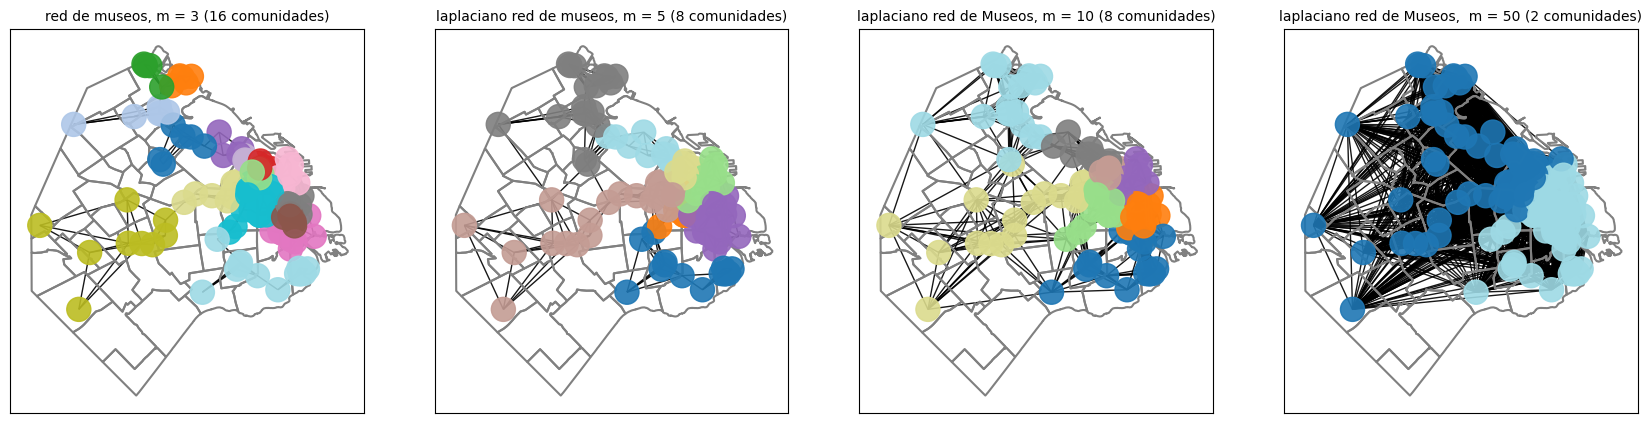

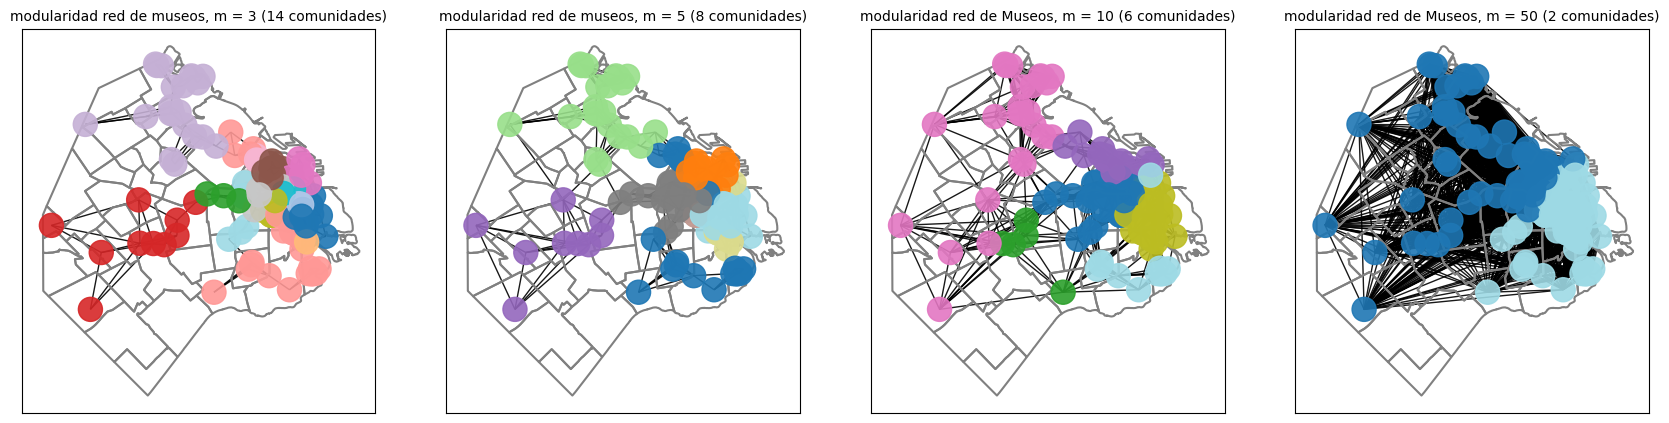

In [19]:
#4 laplaciano
np.random.seed(88)
m3 = 3
A3 = construye_adyacencia(D,m3)

m5 = 5
A5 = construye_adyacencia(D,m5)

m10 = 10
A10 = construye_adyacencia(D,m10)

m50 = 50
A50 = construye_adyacencia(D,m50)

A3 = A_simetrizada(A3)
A5 = A_simetrizada(A5)
A10 = A_simetrizada(A10)
A50 = A_simetrizada(A50)

G3 = nx.from_numpy_array(A3)
G5 = nx.from_numpy_array(A5)
G10 = nx.from_numpy_array(A10)
G50 = nx.from_numpy_array(A50) # Construimos la red a partir de la matriz de adyacencia
# Construimos un layout a partir de las coordenadas geográficas
G_layout = {i:v for i,v in enumerate(zip(museos.to_crs("EPSG:22184").get_coordinates()['x'],museos.to_crs("EPSG:22184").get_coordinates()['y']))}

grupos3 = laplaciano_iterativo(A3,4,nombres_s = None)
l1 = len(grupos3)

grupos5 = laplaciano_iterativo(A5,3,nombres_s=None)
l2 = len(grupos5)

grupos10 = laplaciano_iterativo(A10,3,nombres_s=None)
l3 = len(grupos10)

grupos50 = laplaciano_iterativo(A50,1,nombres_s=None)
l4 = len(grupos50)


listagrupos1=[grupos3,grupos5,grupos10,grupos50]

fig, ax = plt.subplots(1,4,figsize=(21, 7)) # Visualización de la red en el mapa
for i in range (0,4):
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax[i]) # Graficamos Los barrios
for grupo in listagrupos1:
    nodos = G.nodes()
    num_total_museos = max(nodos) + 1

    node_to_group_id = np.full(num_total_museos, -1, dtype=int)
    for group_idx, nodes_in_group in enumerate(grupo):
        for node_id in nodes_in_group:
            node_to_group_id[node_id] = group_idx

    n_coms = len(grupo)


    palette = plt.cm.get_cmap('tab20', n_coms)
    node_colors = [palette(node_to_group_id[n]) for n in nodos]

    if grupo == grupos3:
        nx.draw_networkx(G3,G_layout,ax=ax[0],node_size = 300,node_color=node_colors,alpha = 0.9,with_labels=False) # Graficamos los museos
        ax[0].set_title("red de museos, m = 3 (" + str(l1) + " comunidades)", fontsize=10)
    if grupo == grupos5:
        nx.draw_networkx(G5,G_layout,ax=ax[1],node_size = 300,node_color=node_colors,alpha = 0.9, with_labels=False)
        ax[1].set_title("laplaciano red de museos, m = 5 ("+ str(l2) + " comunidades)", fontsize=10)
    if grupo == grupos10:
        nx.draw_networkx(G10,G_layout,ax=ax[2],node_size = 300,node_color=node_colors,alpha = 0.9, with_labels=False)
        ax[2].set_title("laplaciano red de Museos, m = 10 (" + str(l3) + " comunidades)", fontsize=10)
    if grupo == grupos50:
        nx.draw_networkx(G50,G_layout,ax=ax[3],node_size = 300,node_color=node_colors,alpha = 0.9, with_labels=False)
        ax[3].set_title("laplaciano red de Museos,  m = 50 (" + str(l4) + " comunidades)", fontsize=10)

#4 modularidad
np.random.seed(88)

grupos_3 = modularidad_iterativo(A3,None,None)
l1 = len(grupos_3)

grupos_5 = modularidad_iterativo(A5,None,None)
l2 = len(grupos_5)

grupos_10 = modularidad_iterativo(A10,None,None)
l3 = len(grupos_10)

grupos_50 = modularidad_iterativo(A50,None,None)
l4 = len(grupos_50)

listagrupos = [grupos_3, grupos_5, grupos_10, grupos_50]

fig, ax = plt.subplots(1,4,figsize=(21, 7)) # Visualización de la red en el mapa
for i in range (0,4):
    barrios.to_crs("EPSG:22184").boundary.plot(color='gray',ax=ax[i]) # Graficamos Los barrios
for grupo in listagrupos:
    nodos = G.nodes()
    num_total_museos = max(nodos) + 1
    node_to_group_id = np.full(num_total_museos, -1, dtype=int)
    for group_idx, nodes_in_group in enumerate(grupo):
        for node_id in nodes_in_group:
            node_to_group_id[node_id] = group_idx

    n_coms = len(grupo)


    palette = plt.cm.get_cmap('tab20', n_coms)
    node_colors = [palette(node_to_group_id[n]) for n in nodos]

    if grupo == grupos_3:
        nx.draw_networkx(G3,G_layout,ax=ax[0],node_color = node_colors,node_size = 300,alpha = 0.9,with_labels=False) # Graficamos los museos
        ax[0].set_title("modularidad red de museos, m = 3 (" + str(l1) + " comunidades)", fontsize=10)
    if grupo == grupos_5:
        nx.draw_networkx(G5,G_layout,ax=ax[1],node_color = node_colors,node_size = 300,alpha = 0.9, with_labels=False)
        ax[1].set_title("modularidad red de museos, m = 5 (" + str(l2) + " comunidades)", fontsize=10)
    if grupo == grupos_10:
        nx.draw_networkx(G10,G_layout,ax=ax[2],node_color = node_colors,node_size = 300,alpha = 0.9, with_labels=False)
        ax[2].set_title("modularidad red de Museos, m = 10 (" + str(l3) + " comunidades)", fontsize=10)
    if grupo == grupos_50:
        nx.draw_networkx(G50,G_layout,ax=ax[3],node_color = node_colors,node_size = 300,alpha = 0.9, with_labels=False)
        ax[3].set_title("modularidad red de Museos, m = 50 (" + str(l4) + " comunidades)", fontsize=10)

En los gráficos superiores se representan las particiones óptimas de las comunidades con 3, 5, 10 y 50 conexiones utilizando el laplaciano iterativo. Tomamos la precaución de realizar una cantidad de cortes con el método laplaciano para que formara una cantidad de grupos parecida a la de modularidad, además de fijar una semilla.

En los inferiores se ven las particiones óptimas según la modularidad. Al aumentar la cantidad de conexiones, la modularidad se ve afectada y la separación de los nodos en grupos se dificulta, disminuyendo la cantidad de comunidades.

Notamos que el Laplaciano iterativo busca que todos los grupos tengan pocas conexiones externas; mientras que Modularidad intenta maximizar grupos con mayores conexiones entre sus integrantes. Al variar la semilla, el laplaciano toma otros nodos y la composición de los grupos resulta ser variable, dependiendo del nodo inicial desde el cuál se evalúa el método. Por el contrario, modularidad no parece presentar variaciones en sus agrupamientos.

Comparando todos los gráficos, vemos que para m = 50 los grupos son idénticos para ambos métodos. La densidad de conexiones es tan elevada que ambos objetivos convergen. En general, si el objetivo es tener pocas conexiones externas a los grupos, resulta conveniente tomar los nodos con muchas conexiones entre ellos para cumplir con el objetivo, haciendo que ambos métodos converjan al mismo resultado. De hecho, probamos que al cambiar la seed, ambos métodos devuelvían los mismos gráficos para m = 50.

Para los otros m, los agrupamientos son similares pero igualmente presentan sus diferencias. Por ejemplo, en m = 5 laplaciano prioriza las pocas conexiones por fuera en el grupo marrón, mientras que modularidad toma todo el grupo naranja porque están todos interconectados. En m = 3 laplaciano toma los pequeños grupos del norte aprovechando que están conectados entre sí para minimizar las conexiones por fuera. En cambio, el método de modularidad los junta. Sin embargo, teniendo en cuenta la variabilidad del laplaciano al cambiar la semilla, podría ser posible que de haber inicializado en otro nodo, los agrupamientos fueran iguales.


## Ejercicio 5:
Luego de haber realizado este trabajo grupal, hemos llegado a varias conclusiones con respecto a lo observado en la red de museos, los resultados obtenidos, los métodos utilizados y también los datasets empleados.

Observando la red de museos, vimos cómo la posición de cada uno dentro de un mapa influía en sus conexiones totales, dado que las aristas dependían de la distancia entre ellos. Variando los parámetros de entrada (azar, cantidad de conexiones, cantidad de grupos) pudimos observar distintos resultados:

En la primera parte pudimos ver que el azar aumentaba o disminuía el peso de las conexiones en el valor del pagerank. Tener un azar bajo asignaba un alto valor a las conexiones, y unos pocos museos centrales acaparaban todos los visitantes al crecer la cantidad de conexiones directas en ese caso. Si el azar era elevado, las conexiones perdían sentido. 

Con respecto a la segunda parte, tomamos los museos y únicamente miramos sus conexiones. Los agrupamos en base a ello: laplaciano buscaba minimizar las conexiones externas de la cantidad de grupos asignada, y modularidad buscaba maximizar las conexiones internas dentro de cada grupo. Al tener una cantidad de conexiones entre museos elevada, ambos métodos convergían (pidiendole a laplaciano que forme la misma cantidad de grupos que modularidad). De hecho, apreciamos que al cambiar la semilla, en ese caso ambos métodos devolvían los mismos gráficos. 
Podríamos decir que de alguna manera los métodos laplaciano y modularidad calculan una suerte de "pagerank" para decidir cómo agrupar los nodos en base a las conexiones que reciben.

Con los métodos utilizados aprendimos a trabajar y construir matrices que cumplen con distintas características. Tuvimos que buscarle la vuelta a las propiedades y definiciones vistas en clase para así poder argumentar las pruebas en los ejercicios. Además aprendimos a graficar los museos sobre mapas, con sus aristas y pintandolos según su agrupamiento, utilizando librerías como geopandas, networkx y matplotlib.

Sobre los datasets empleados, pudimos hacer buenas interpretaciones de los agrupamientos gracias al mapa de museos. Utilizamos visitas.txt y basandonos en Markov vimos que se puede desandar la noche de los museos y saber las visitas iniciales a partir de las visitas totales.

En conclusión, notamos un amplio aprendizaje sobre la red de museos y su comportamiento en distintas situaciones, la elaboración e interpretación de gráficos, demostración de distintas propiedades y el trabajar en equipo.
